In [2]:
%pylab inline
import geopandas as gpd
import rasterio as rio
import rasterio.plot as rplot
import itertools

Populating the interactive namespace from numpy and matplotlib


In [3]:
dem_path = "MARS-Dataset/training_site/"
mounds_f = "MARS-Dataset/training_site/mapping/polygons/mounds.shp"
dem_f = "MARS-Dataset/training_site/DEM/High-res_DEM/Firsoff_HiRISE_5.tif-adj.tif"
vents_f = "MARS-Dataset/training_site/mapping/points/vent_points.shp"

In [4]:
import os 
filestem = os.path.splitext(os.path.basename(dem_f))[0]
filestem

'Firsoff_HiRISE_5.tif-adj'

In [5]:
data = gpd.read_file(mounds_f)

toremove = []
for id, gg in enumerate(data.geometry):
    if not gg.is_valid:
        print(f"not valid {id}")
        toremove.append(id)

data = data.drop(toremove)
data.drop_duplicates(inplace=True)

vents = gpd.read_file(vents_f)



not valid 56
not valid 92
not valid 100
not valid 163
not valid 200
not valid 329
not valid 330


In [6]:
#Simple Mounds
simple_mounds = data[data.Morpho == "simple"]

PROJCS["Mars_Sinusoidal",GEOGCS["GCS_Mars_Sphere",DATUM["D_Mars_Sphere",SPHEROID["Mars_Sphere",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",350],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


<AxesSubplot:>

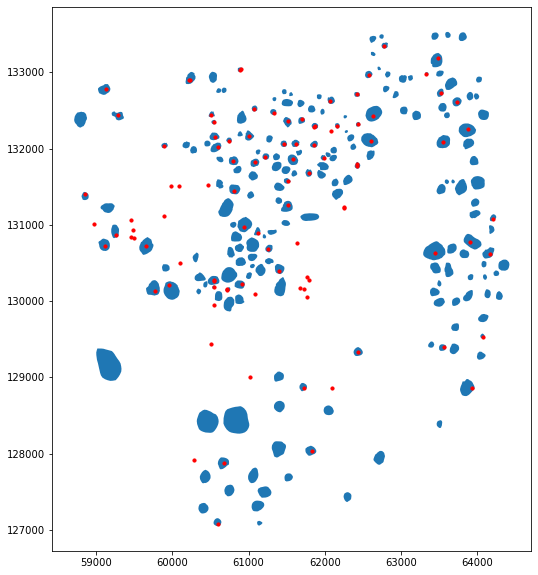

In [7]:
print(simple_mounds.crs)
figure(figsize = (10,10))
simple_mounds.plot(ax=gca())
vents.plot(ax=gca(), color = "red", markersize=10)

In [8]:
dem_source = rio.open(dem_f)
dtm = dem_source.read()
meta = dem_source.meta

In [9]:
dtm

array([[[-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        ...,
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.]]],
      dtype=float32)

In [18]:
np.min(dtm)

-32767.0

NameError: name 'your_image' is not defined

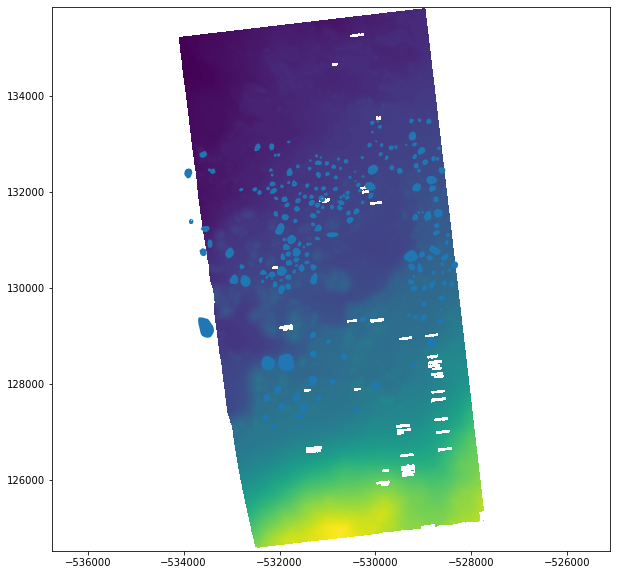

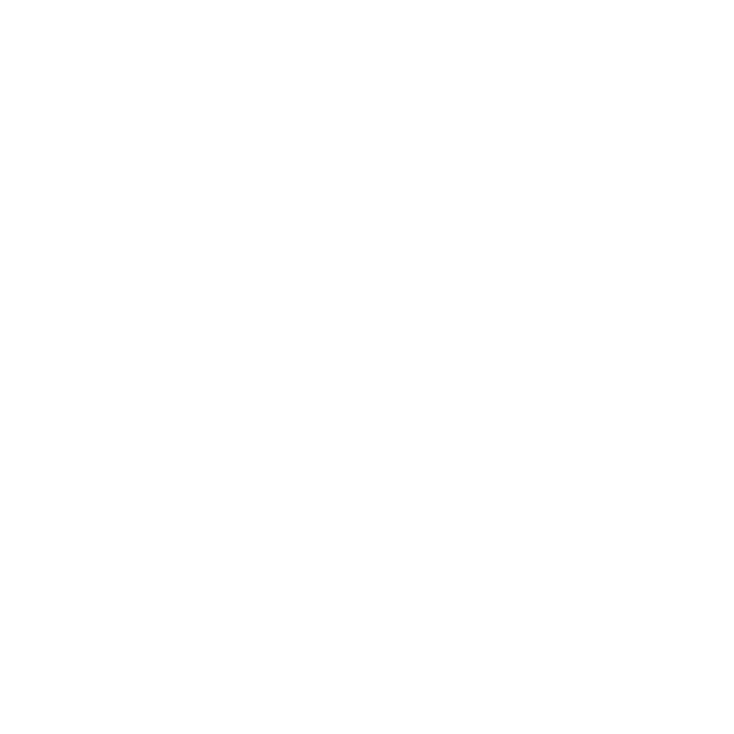

In [25]:
figure(figsize=(10,10))
axis("equal")
rplot.show(dem_source, ax=gca())
data_ = simple_mounds.to_crs(meta["crs"])
data_.plot(ax=gca(), column = "Morpho")
fig = plt.figure(frameon=False)
fig.set_size_inches(10,10)
# To make the content fill the whole figure

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
# Then draw your image on it :

ax.imshow(your_image, aspect='auto')
fig.savefig('out1.png', dpi)
# fig.savefig('out1.png', bbox_inches='tight', pad_inches=0)
grid()

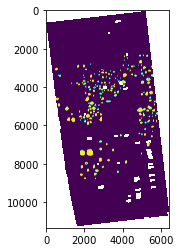

In [11]:
from rasterio import mask

### Loading DEM source. 

dsource= rio.open(dem_f)
dtm = dsource.read()
meta = dsource.meta
### Reprojecting the labels coordinate system to that of the original DEM. 
mounds_corrected  =simple_mounds.to_crs(meta['crs'])

### Masking the labels. 0 for non mounds, 1 for mounds. Can be used for segmentation. 

out_img, out_transform =mask.mask(dataset=dsource, shapes = mounds_corrected.geometry, nodata=np.nan) 

# do the crop 
out_img = out_img[0]
nodata = meta["nodata"] 
invalid_elevation = dtm[0] == nodata 
isnan = np.isnan(out_img) 
out_img[isnan] = 0
out_img[~isnan] = 1 
out_img[invalid_elevation] = np.nan # overall mask 0 non mounds, 1 mounds, np.nan unknown
to_enlarge_mounds = out_img

figure() 
imshow(out_img)
plt.savefig("corredcted Mounds.png")

In [12]:
import rasterio.mask as mask

In [13]:
import shutil

tmp = shutil.copy(dem_f, "tmp1.tif")
src = rio.open(tmp, mode="r+")
src.write_mask(False)
src.read_masks(1).all()
src.close()

In [13]:
src = rio.open("tmp1.tif")

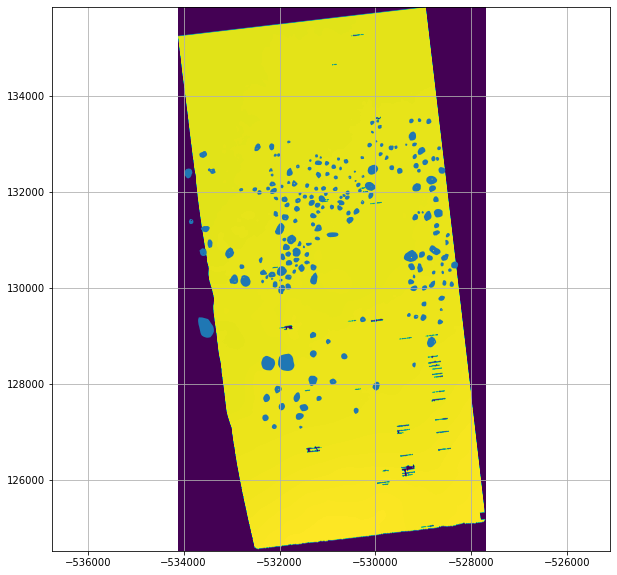

In [14]:
figure(figsize=(10,10))
# imshow(src, interpolation=None)
axis("equal")
rplot.show(src, ax=gca())
data_ = simple_mounds.to_crs(meta["crs"])
data_.plot(ax=gca(), column = "Morpho")
plt.savefig("mounds.png", bbox_inches='tight')
grid()

In [15]:
src.close()

In [16]:
src.transform

Affine(1.0, 0.0, -534126.5,
       0.0, -1.0, 135856.5)

In [17]:
mounds_enlarged = []
for i, geometry in enumerate(data_.geometry):
    enlarged = geometry.buffer(2)
    from shapely.geometry import Polygon
    pp = Polygon.from_bounds(*geometry.bounds)
    
    out_img, out_transform = mask.mask(dataset=dem_source, shapes=[enlarged], nodata=np.nan, crop=True, all_touched=True, filled=True, pad=False)
    
    mounds_enlarged.append((out_img[0], i))
    
#     if np.any(np.isnan(out_img)):
#         print(f"{i} has nans")
#         continue
        

In [18]:
# for mound, mound_id in mounds_enlarged:
#     figure()
#     imshow(mound)
#     title(f"id {mound_id}")
# plt.savefig('{0:s}_interp.png'.format(dem_path+"Enlarged Mounds/"+str(mound_id)), dpi=100)

In [19]:
from scipy.interpolate import griddata

In [20]:
def make_interpolated_image(nsamples, im, method):
    """Make an interpolated image from a random selection of pixels.

    Take nsamples random pixels from im and reconstruct the image using
    scipy.interpolate.griddata.

    """

    ix = np.random.randint(im.shape[1], size=nsamples)
    iy = np.random.randint(im.shape[0], size=nsamples)
    samples = im[iy,ix]
    int_im = griddata((iy, ix), samples, (Y, X),method=method)
    return int_im

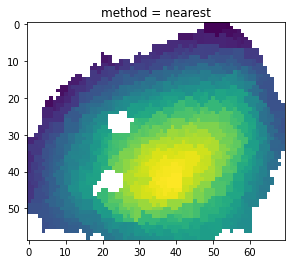

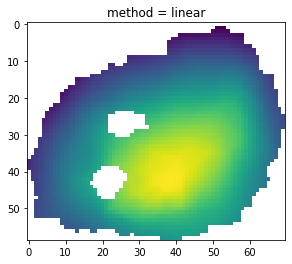

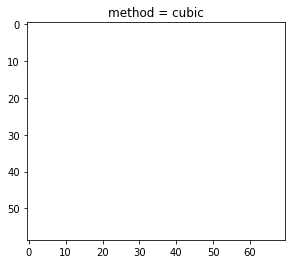

In [23]:
for mound, mound_id in mounds_enlarged:
    # A meshgrid of pixel coordinates
    nx, ny = mound.data.shape[1], mound.data.shape[0]
    X, Y = np.meshgrid(np.arange(0, nx, 1), np.arange(0, ny, 1))


    methods=["nearest", "linear", "cubic"]

    nsamples = 1000
    if mound_id ==7:
      for method in methods:
        figure()
        imshow(make_interpolated_image(nsamples, mound, method))
        title('method = {0:s}'.format(method))
#     filestem = os.path.splitext(os.path.basename(img_name))[0]
#     plt.savefig('{0:s}_interp.png'.format(filestem), dpi=100)